# Cleaning the newspaper archive

In [106]:
import os
import re
import json
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial
from itertools import product
from collections import Counter
from unicodedata import category
from utils import multicore_apply

import fasttext
from umap import UMAP
from scipy.linalg import norm
from reo_toolkit import is_maori
from gensim.models import Phrases
from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
from numba.errors import NumbaWarning
warnings.filterwarnings("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = NumbaWarning)

In [5]:
def remove_punctuation(text):
    return ''.join(ch for ch in text if category(ch)[0] != 'P')
    
def normalize_text(text):
    text = re.sub("\s{2,}", " ", text)
    return remove_punctuation(text.lower())

## Cleaning the text

In [6]:
with open('../data/maori_newspapers.json', 'r') as f:
    papers = pd.DataFrame(json.load(f))

In [7]:
col_patterns = {
    'newspaper_id': '([A-Z]+)[^/]+$',
    'year': '[A-Z]+([0-9]{4})[^/]+$',
    'month': '[A-Z]+[0-9]{4}([0-9]{2})[^/]+$',
    'day': '[A-Z]+[0-9]{6}([0-9]{2})[^/]+$',
    'id': '[A-Z]+[0-9]+\.([^/]+)$'
}

for col, pattern in col_patterns.items():
    papers[col] = papers.url.str.extract(pattern)

papers.head()

,url,text,newspaper_id,year,month,day,id
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11
2,https://paperspast.natlib.govt.nz/newspapers/A...,KI WGA MAORI : '• ■ ‘ ■ ■ - ■ ■ ; 1 SVgil c.la...,AONUPEP,1892,06,04,2.14.1
3,https://paperspast.natlib.govt.nz/newspapers/A...,HE MEA TUKU MAI E NGA WHARE ERUA O TE PAREMATA...,AONUPEP,1892,06,04,2.13
4,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1


In [8]:
papers['paragraph'] = papers.text.apply(lambda s: s.split("\n"))
papers = papers.explode('paragraph')

In [9]:
%%time
papers['sentence'] = multicore_apply(papers.paragraph, sent_tokenize)
papers = papers.explode('sentence')
papers = papers[~papers.sentence.isna()]

papers.head()

100%|██████████| 94.3k/94.3k [00:00<00:00, 220kit/s]  
94346it [00:00, 503202.98it/s]


CPU times: user 21.6 s, sys: 3.21 s, total: 24.8 s
Wall time: 22.4 s


,url,text,newspaper_id,year,month,day,id,paragraph,sentence
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","WANTKD, a smart LAD, ' and n rite."
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","Apply ai Zi alamli'i"" Office."
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","""Na te Tika i toa ai."""
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","Turei, Huri 17, 1848."


In [10]:
# Print the number of sentences in te_ara
print("There are {} sentences in the māori newspaper archive".format(len(papers)))

There are 805342 sentences in the māori newspaper archive


Here are the first 5 sentences:

In [11]:
print('\n'.join(papers.sentence[:5]))

WANTKD, a smart LAD, ' and n rite.
Apply ai Zi alamli'i" Office.
KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
"Na te Tika i toa ai."
Turei, Huri 17, 1848.


## Text cleaning

In [12]:
def extract_words(text):
    text = text.lower()
    results = []
    for word in word_tokenize(text):
        if re.search('[a-zāēīōū]', word):
            result = re.sub('\s{2,}', ' ',
                re.sub('[^a-zāēīōū]', ' ', word)
            )
            for res in result.split():
                results.append(res)
    return results

In [13]:
%%time
papers['words'] = multicore_apply(papers['sentence'], extract_words)

100%|██████████| 805k/805k [00:02<00:00, 277kit/s]     
805342it [00:01, 553134.69it/s]


CPU times: user 2min 50s, sys: 21.2 s, total: 3min 11s
Wall time: 2min 52s


In [14]:
word_counts = papers['words'].explode().value_counts()
word_counts = word_counts.to_frame().reset_index()
word_counts.columns = ['word', 'count']
word_counts.to_csv('../data/papers_word_counts.csv', index = False)
word_counts

,word,count
0,te,763785
1,i,643241
2,e,388836
3,nga,356423
4,o,355744
...,...,...
441061,pearauc,1
441062,ripeno,1
441063,quanta,1
441064,tonra,1


In [15]:
def drop_macrons(text):
    macron_dict = {
        'ā': 'a',
        'ē': 'e',
        'ī': 'i',
        'ō': 'o',
        'ū': 'u',
        'Ā': 'A',
        'Ē': 'E',
        'Ī': 'I',
        'Ō': 'O',
        'Ū': 'U',
    }
    
    for k, v in macron_dict.items():
        text = text.replace(k, v)
    
    return text

In [16]:
te_ara_word_counts = pd.read_csv("../data/te_ara_word_counts.csv")

te_ara_word_counts = te_ara_word_counts[~te_ara_word_counts.word.isna()]
te_ara_word_counts['word'] = te_ara_word_counts.word.apply(drop_macrons)
te_ara_word_counts = (te_ara_word_counts
    .groupby('word')
    .sum('count')
    .reset_index()
    .sort_values('count', ascending = False)
    .reset_index(drop = True)
)

te_ara_word_counts

,word,count
0,te,189195
1,i,116967
2,o,72256
3,ki,57855
4,nga,57162
...,...,...
24241,ngahorotanga,1
24242,ngahuka,1
24243,ngainui,1
24244,ngaitai,1


In [17]:
papers_word_counts = word_counts
papers_word_counts.columns = ['word', 'papers_count']
te_ara_word_counts.columns = ['word', 'te_ara_count']

In [18]:
word_counts = papers_word_counts.merge(te_ara_word_counts, how = 'left', on = ['word']).fillna(0)
word_counts

,word,papers_count,te_ara_count
0,te,763785,189195.0
1,i,643241,116967.0
2,e,388836,32359.0
3,nga,356423,57162.0
4,o,355744,72256.0
...,...,...,...
441061,pearauc,1,0.0
441062,ripeno,1,0.0
441063,quanta,1,0.0
441064,tonra,1,0.0


In [19]:
word_counts[word_counts.te_ara_count == 1]

,word,papers_count,te_ara_count
276,kaati,6265,1.0
312,ete,5359,1.0
362,ekore,4510,1.0
397,say,3891,1.0
432,per,3367,1.0
...,...,...,...
438903,polytechnic,1,1.0
439180,haweis,1,1.0
439641,hewitt,1,1.0
439837,pukeora,1,1.0


In [20]:
word_counts[word_counts.te_ara_count == 0]

,word,papers_count,te_ara_count
78,ote,26338,0.0
105,tc,19631,0.0
141,lie,13875,0.0
258,tons,6955,0.0
286,lo,5932,0.0
...,...,...,...
441061,pearauc,1,0.0
441062,ripeno,1,0.0
441063,quanta,1,0.0
441064,tonra,1,0.0


## Phrase modelling

We can use gensim to join common phrases in the text.

In [21]:
def phrase_model(lines, min_count, threshold, phrase_length):
    
    for _ in range(phrase_length):
        sentence_stream = [doc.split(" ") for doc in lines]
        bigram = Phrases(sentence_stream, min_count=min_count, threshold=threshold)
        lines = [' '.join(bigram[line.split()]) for line in lines]
        
    return lines

In [22]:
maori_words  = set(word for word in papers_word_counts.word if is_maori(word))
te_ara_words = set(word for word in te_ara_word_counts.word if is_maori(word))

In [25]:
%%time
papers['phrase'] = phrase_model(
    (papers.words
        .apply(lambda x: ' '.join(
            [y for y in x if y in te_ara_words or y in maori_words]
        ))),
    min_count = 30,
    threshold = 10,
    phrase_length = 5
)

CPU times: user 4min 59s, sys: 199 ms, total: 4min 59s
Wall time: 4min 59s


In [26]:
%%time
phrase_counts = papers.phrase.apply(str.split).explode().value_counts().to_frame().reset_index()
phrase_counts.columns = ['word', 'count']
phrase_counts

CPU times: user 6.76 s, sys: 0 ns, total: 6.76 s
Wall time: 6.76 s


,word,count
0,te,763785
1,e,388836
2,nga,356423
3,o,355744
4,ki,259854
...,...,...
124091,imirope,1
124092,tonapupuri,1
124093,pariia,1
124094,tirinita,1


In [27]:
phrase_counts[phrase_counts.word.str.contains("_")]

,word,count
256,niu_tireni,3423
293,muri_iho,2940
508,hau_hau,1395
513,nui_tireni,1368
525,hoa_riri,1332
...,...,...
87910,kakaurakaraka_waea_taiepa,1
97590,kaheru_kota,1
103288,mihini_rui,1
111908,whanau_kotoa,1


## Train fasttext model

In [28]:
corpus_file = '../data/papers_corpus.txt'

In [29]:
with open(corpus_file, 'w') as f:
    for line in papers.loc[papers.phrase.str.len() != 0, 'phrase']:
        f.write(line)

In [30]:
%%time
model = fasttext.train_unsupervised(corpus_file, minCount = 30)

CPU times: user 8min 30s, sys: 539 ms, total: 8min 30s
Wall time: 36.6 s


In [82]:
model_data = pd.DataFrame({'word': model.words})
model_data['word_vector'] = model_data.word.apply(model.get_word_vector)
model_data

,word,word_vector
0,te,"[-0.20888044, -0.0040204003, -0.06004022, 0.23..."
1,nga,"[-0.12939869, -0.12081314, -0.28781164, 0.2635..."
2,e,"[-0.08031787, 0.07808459, -0.11325997, 0.10357..."
3,o,"[0.11238288, 0.09894422, -0.29224262, 0.312921..."
4,ki,"[-0.03736827, 0.05390022, -0.35841614, 0.33961..."
...,...,...
7977,maoriu,"[0.11663112, 0.18552831, -0.14113002, 0.326281..."
7978,noma,"[0.04047368, 0.48602483, -0.25612545, 0.400876..."
7979,naonao,"[0.2988457, 0.3650965, 0.38670313, -0.41320926..."
7980,utuheoi,"[-0.3477375, 0.21860187, 0.045559738, 0.163318..."


In [122]:
model_data[model_data.word.str.contains("_")]

,word,word_vector,count,n_neighbors,min_dist,x,y
283,niu_tireni,"[0.07465542, 0.41598034, -0.34814337, 0.543938...",1.0,2,0.2,10.244912,-4.591726
362,muri_iho,"[0.18710558, -0.13745353, 0.21392938, 0.194914...",1.0,2,0.2,11.194809,-10.962046
511,hoa_riri,"[-0.34915194, -0.21153295, -0.5456071, 0.29637...",1.0,2,0.2,12.863962,-10.835375
523,hau_hau,"[-0.37714338, -0.6584565, 0.05017009, 0.065822...",1.0,2,0.2,16.041063,-4.796984
609,nui_tireni,"[0.007104596, 0.58078647, -0.26354164, 0.33515...",1.0,2,0.2,11.018269,-5.320415
...,...,...,...,...,...,...,...
7883,taiepa_kakau,"[-0.18100731, -0.27994138, -0.6934744, -0.3542...",1.0,2,0.2,5.775962,1.824027
7898,mita_karaka,"[-0.22993492, -0.33708242, 0.44427842, -0.4023...",1.0,2,0.2,12.208487,-15.630664
7956,taare_tikao,"[-0.28568393, 0.48796675, -0.28069103, -0.1427...",1.0,2,0.2,9.482637,-12.316849
7961,anaru_patene,"[-0.14623962, -0.124857314, 0.22993124, -0.129...",1.0,2,0.2,17.946648,-8.684016


In [83]:
model_data['count'] = model_data.merge(word_counts, how = 'left', on = ['word'])['papers_count'].fillna(1)

In [84]:
model_data

,word,word_vector,count
0,te,"[-0.20888044, -0.0040204003, -0.06004022, 0.23...",763785.0
1,nga,"[-0.12939869, -0.12081314, -0.28781164, 0.2635...",356423.0
2,e,"[-0.08031787, 0.07808459, -0.11325997, 0.10357...",388836.0
3,o,"[0.11238288, 0.09894422, -0.29224262, 0.312921...",355744.0
4,ki,"[-0.03736827, 0.05390022, -0.35841614, 0.33961...",259854.0
...,...,...,...
7977,maoriu,"[0.11663112, 0.18552831, -0.14113002, 0.326281...",1.0
7978,noma,"[0.04047368, 0.48602483, -0.25612545, 0.400876...",41.0
7979,naonao,"[0.2988457, 0.3650965, 0.38670313, -0.41320926...",38.0
7980,utuheoi,"[-0.3477375, 0.21860187, 0.045559738, 0.163318...",1.0


In [85]:
word_vectors = np.vstack(model_data.word_vector.apply(lambda x: x / norm(x)))

In [86]:
similarity_matrix = np.dot(word_vectors, word_vectors.transpose())

## Dimensionality reduction with UMAP

In [95]:
model_data

,word,word_vector,count,n_neighbors,min_dist,x,y
0,te,"[-0.20888044, -0.0040204003, -0.06004022, 0.23...",763785.0,2,0.2,-5.214829,1.217427
1,nga,"[-0.12939869, -0.12081314, -0.28781164, 0.2635...",356423.0,2,0.2,4.175197,-4.535711
2,e,"[-0.08031787, 0.07808459, -0.11325997, 0.10357...",388836.0,2,0.2,-5.224579,2.482552
3,o,"[0.11238288, 0.09894422, -0.29224262, 0.312921...",355744.0,2,0.2,-5.104189,2.624603
4,ki,"[-0.03736827, 0.05390022, -0.35841614, 0.33961...",259854.0,2,0.2,-5.125865,2.611188
...,...,...,...,...,...,...,...
7977,maoriu,"[0.11663112, 0.18552831, -0.14113002, 0.326281...",1.0,2,0.2,-6.479691,15.842945
7978,noma,"[0.04047368, 0.48602483, -0.25612545, 0.400876...",41.0,2,0.2,-4.496148,7.301092
7979,naonao,"[0.2988457, 0.3650965, 0.38670313, -0.41320926...",38.0,2,0.2,-0.233571,18.605818
7980,utuheoi,"[-0.3477375, 0.21860187, 0.045559738, 0.163318...",1.0,2,0.2,8.475215,5.773671


In [98]:
def calculate_umap(params, umap_data, similarity_matrix):
    neighbors, dist = params

    reducer = UMAP(n_neighbors = neighbors, min_dist = dist)
    reduced = reducer.fit_transform(similarity_matrix)

    umap_data['n_neighbors'] = neighbors
    umap_data['min_dist'] = dist
    
    umap_data['x'] = reduced[:, 0]
    umap_data['y'] = reduced[:, 1]

    umap_data = umap_data[['n_neighbors', 'min_dist', 'word', 'count', 'x', 'y']]

    umap_data['rank'] = np.arange(len(umap_data))

    umap_data = umap_data[umap_data.word != '</s>']

    umap_data.columns = ['n_neighbors', 'min_dist', 'word', 'word_count', 'x_coord', 'y_coord', 'rank']

    return umap_data

In [100]:
%%time
n_neighbours = [2, 5, 10, 20, 50, 100, 200]
min_dist = [0.2, 0.4, 0.6, 0.8, 0.95, 0.99]

umap_results = pd.concat(
    multicore_apply(
        product(n_neighbours, min_dist), 
        partial(calculate_umap, 
                umap_data = model_data,
                similarity_matrix = similarity_matrix))
)

100%|██████████| 42.0/42.0 [05:46<00:00, 8.26s/it]
42it [00:00, 171696.65it/s]

CPU times: user 12.4 s, sys: 16.8 s, total: 29.3 s
Wall time: 5min 48s


In [125]:
umap_results[umap_results.word.str.contains('_')]

,n_neighbors,min_dist,word,word_count,x_coord,y_coord,rank
283,2,0.20,niu_tireni,1.0,17.084753,9.486196,283
362,2,0.20,muri_iho,1.0,6.365375,0.259624,362
511,2,0.20,hoa_riri,1.0,8.325623,16.140591,511
523,2,0.20,hau_hau,1.0,9.046195,4.296887,523
609,2,0.20,nui_tireni,1.0,17.025316,9.513303,609
...,...,...,...,...,...,...,...
7883,200,0.99,taiepa_kakau,1.0,2.930180,-7.878190,7883
7898,200,0.99,mita_karaka,1.0,8.128142,0.364303,7898
7956,200,0.99,taare_tikao,1.0,4.070405,1.836684,7956
7961,200,0.99,anaru_patene,1.0,5.800498,-0.108825,7961


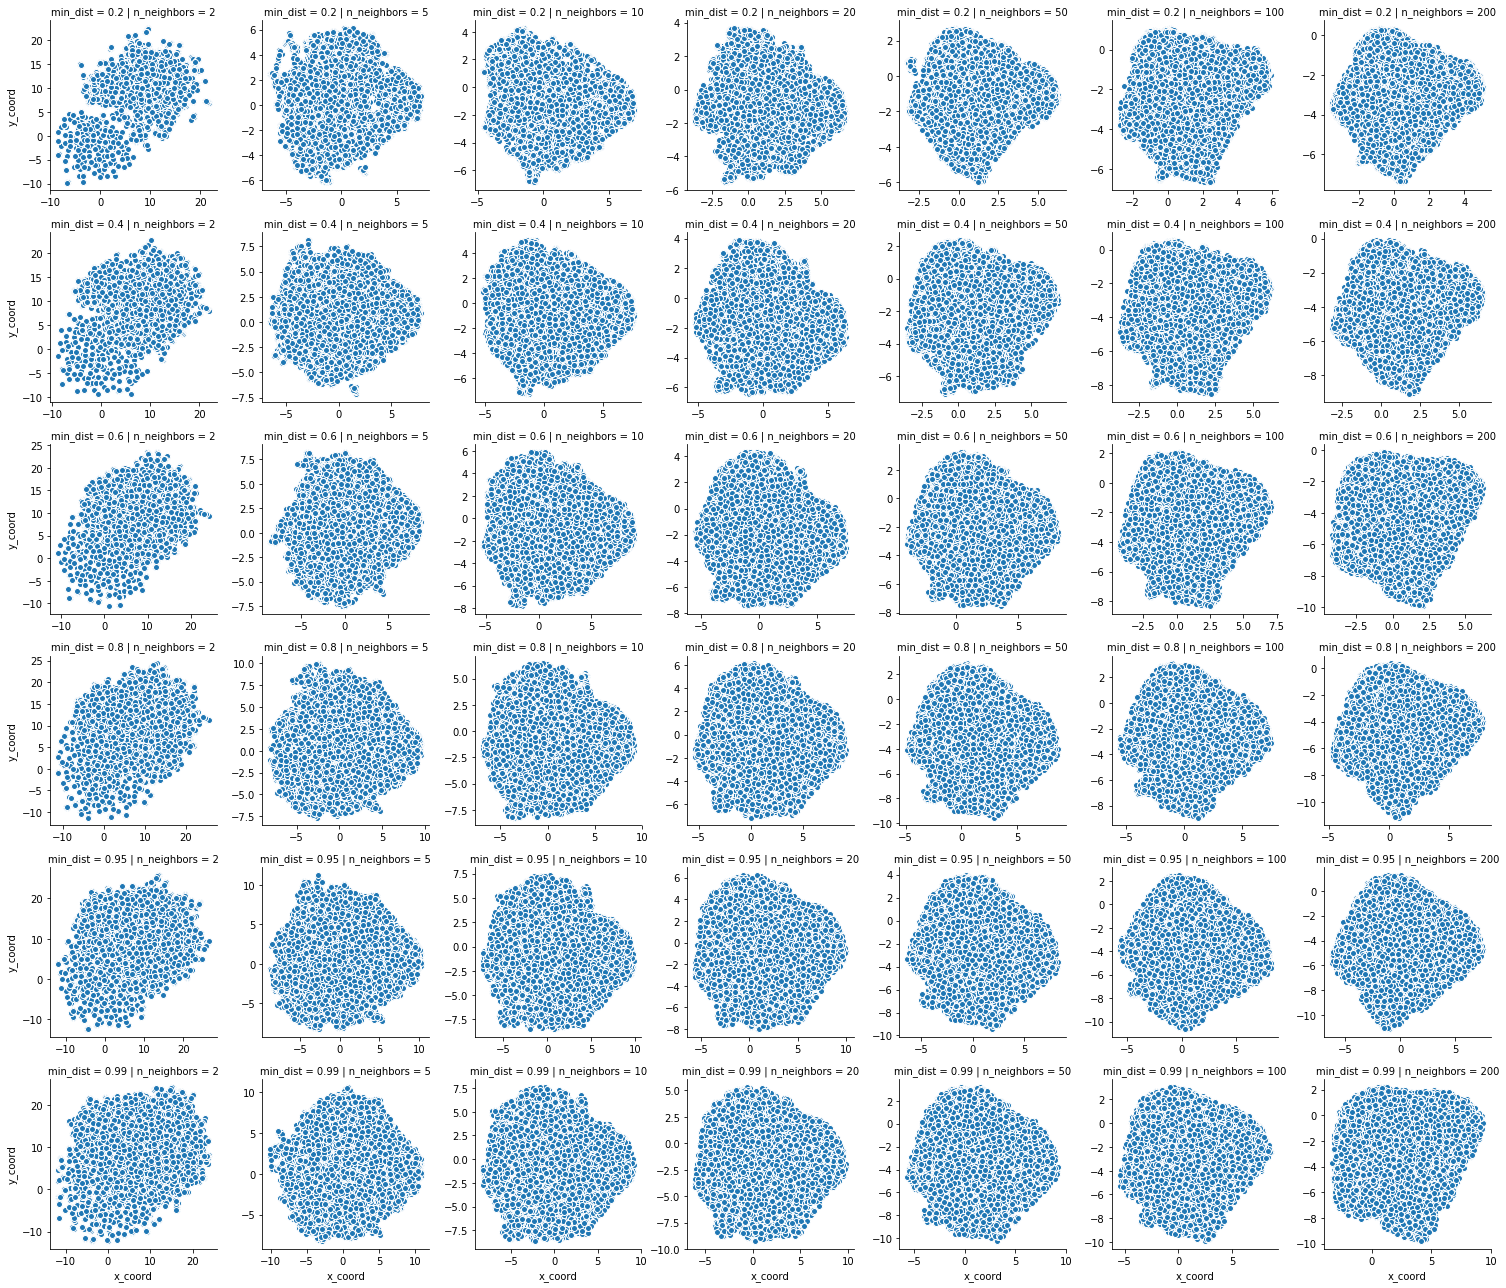

In [107]:
g = (sns.FacetGrid(umap_results, col="n_neighbors", row="min_dist", sharex = False, sharey = False)
    .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
)

In [127]:
(umap_results
     .loc[
        (umap_results.n_neighbors == 20) & \
        (umap_results.min_dist == 0.8) & \
        (umap_results.word_count > 30) |
        (umap_results.word.str.contains("_")),
        ['word', 'word_count', 'x_coord', 'y_coord', 'rank']
     ].reset_index(drop = True)
      .to_csv('../data/umap.csv', index = False)
)

In [131]:
(umap_results
     .loc[
        (umap_results.n_neighbors == 20) & \
        (umap_results.min_dist == 0.8) & \
        (umap_results.word_count > 30) |
        (umap_results.word.str.contains("_")),
        ['word', 'word_count', 'x_coord', 'y_coord', 'rank']
     ].sort_values('word_count', ascending = False)
      .reset_index(drop = True)
)

,word,word_count,x_coord,y_coord,rank
0,te,763785.0,-0.875960,-0.984520,0
1,e,388836.0,-0.932034,-0.648100,2
2,nga,356423.0,-1.260055,-0.838719,1
3,o,355744.0,-0.775640,-1.319587,3
4,ki,259854.0,-0.859933,-1.015665,4
...,...,...,...,...,...
27157,korimako_pouaka_poutapeta,1.0,2.529223,4.257665,4911
27158,manuhiri_tuarangi,1.0,3.255396,-1.095389,4906
27159,niu_tirenie,1.0,-1.564151,1.275993,4893
27160,hohou_rongo,1.0,2.353403,-0.149339,4891


## Saving output to disk

In [ ]:
papers.to_csv('../data/papers.csv', index = False)